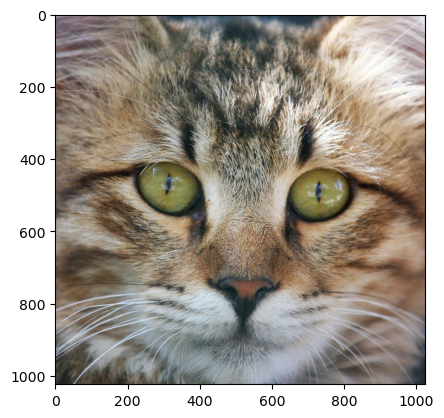

In [11]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import lovely_tensors as lt
import os
import imageio.v2 as imageio
import numpy as np
import torch
lt.monkey_patch()
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Download image, take a square crop from the center
image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]
plt.imshow(img)
plt.show()

Shape of xy: torch.Size([64, 2])
First few values of xy:
 tensor[5, 2] n=10 x∈[0.103, 0.946] μ=0.359 σ=0.277 [[0.312, 0.199], [0.103, 0.665], [0.946, 0.213], [0.123, 0.297], [0.560, 0.168]]

Shape of rgb: torch.Size([64, 3])
First few values of rgb:
 tensor[5, 3] n=15 x∈[0.247, 0.663] μ=0.420 σ=0.145


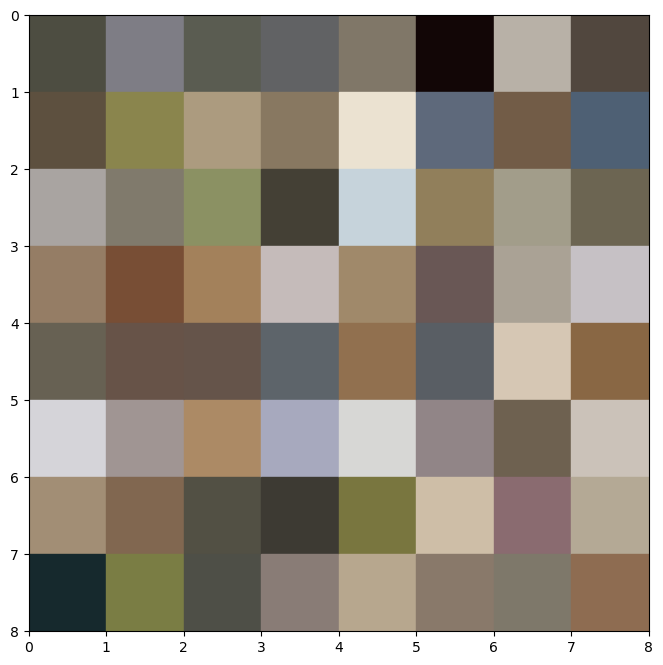

In [13]:
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, img):
        h, w, c = img.shape
        # Create a meshgrid of positions
        x = np.linspace(0, 1, w)
        y = np.linspace(0, 1, h)
        xv, yv = np.meshgrid(x, y)
        positions = np.stack((xv, yv), axis=-1)

        self.X = torch.from_numpy(positions.reshape(-1, 2)).float()  # shape (h*w, 2)
        self.Y = torch.from_numpy(img.reshape(-1, c)).float() / 255.0  # Normalize to [0, 1] range, shape (h*w, 3)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.Y[idx, :]


dataset = CustomImageDataset(img)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
xy, rgb = next(iter(loader))
xy, rgb
print("Shape of xy:", xy.shape)
print("First few values of xy:\n", xy[:5])

print("\nShape of rgb:", rgb.shape)
print("First few values of rgb:\n", rgb[:5])
plt.figure(figsize=(8,8))
for i in range(8):
    for j in range(8):
        plt.fill([i, i+1, i+1, i], [j, j, j+1, j+1], color=rgb[8*i + j].numpy())  # divide by 255 to bring colors to [0, 1] range
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.gca().invert_yaxis()  # invert y-axis to align with image coordinates
plt.show()


In [16]:
import torch.nn as nn
import torch

def pos_enc(x, num_freqs=6):
    x = x[:, :, None]
    freqs = torch.pow(2.0, torch.linspace(0.0, num_freqs - 1, num_freqs))
    angles = x * freqs
    pos_encoding = torch.cat([torch.sin(angles), torch.cos(angles)], axis=-1)
    return pos_encoding.reshape(pos_encoding.shape[0], -1)

# Neural Network Model
class Net(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dims=[128], **kwargs):
        super().__init__()
        self.layers = nn.ModuleList()

        self.pos_enc_params = kwargs.get('pos_enc_params', {})
        num_freqs = self.pos_enc_params.get('num_freqs', 6)
        inp_dim *= 2 * num_freqs 
        
        curr_dim = inp_dim
        for dim in hid_dims:
            self.layers.append(nn.Linear(curr_dim, dim))
            curr_dim = dim
        self.nonlin = nn.ReLU()
        self.out = nn.Linear(curr_dim, out_dim)

    def forward(self, x):
        z = pos_enc(x, **self.pos_enc_params)
        for layer in self.layers:
            z = self.nonlin(layer(z))
        return self.out(z)

# Test your architecture
net = Net(2, 3, [128, 128])
batch_size = 1234
net(torch.ones((batch_size, 2)))

tensor[1234, 3] n=3702 (14Kb) x∈[0.030, 0.091] μ=0.057 σ=0.025 grad AddmmBackward0

In [19]:
import torch.nn.functional as F
from torch.optim import Adam

# Define metrics
def compute_psnr(gtr, out):
    mse = F.mse_loss(gtr, out)
    psnr = -10 * torch.log10(mse)
    return psnr.item()

# Define loss function
def compute_loss(out, y):
    return F.mse_loss(out, y)

# Initialize optimizer
net = Net(2, 3, hid_dims=[256, 256, 256], pos_enc_params={'num_freqs': 8})
opt = Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2500, gamma=0.5)  # Add a learning rate scheduler

data_iter = iter(loader)
for iteration in range(20000):  # The final quality could be better if use like higher numbers but I think there is no significant improvement between 15000 and 20000 (I tested both).
    try:
        x, y = next(data_iter)
    except StopIteration:
        data_iter = iter(loader)
        x, y = next(data_iter)

    opt.zero_grad()
    out = net(x)
    loss = compute_loss(out, y)
    loss.backward()
    opt.step()
    scheduler.step()

    # Monitor the training every 100 iterations
    if iteration % 100 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item()}, PSNR: {compute_psnr(y, out)}")




Iteration 0, Loss: 0.2852369248867035, PSNR: 5.447942733764648
Iteration 100, Loss: 0.02225467748939991, PSNR: 16.525787353515625
Iteration 200, Loss: 0.02166721783578396, PSNR: 16.6419677734375
Iteration 300, Loss: 0.0148576395586133, PSNR: 18.280502319335938
Iteration 400, Loss: 0.01582050696015358, PSNR: 18.007795333862305
Iteration 500, Loss: 0.010235988534986973, PSNR: 19.89870262145996
Iteration 600, Loss: 0.009750756435096264, PSNR: 20.109617233276367
Iteration 700, Loss: 0.01024021115154028, PSNR: 19.89691162109375
Iteration 800, Loss: 0.010249228216707706, PSNR: 19.893089294433594
Iteration 900, Loss: 0.0066487728618085384, PSNR: 21.772584915161133
Iteration 1000, Loss: 0.012491249479353428, PSNR: 19.0339412689209
Iteration 1100, Loss: 0.009407133795320988, PSNR: 20.265426635742188
Iteration 1200, Loss: 0.009250557981431484, PSNR: 20.338321685791016
Iteration 1300, Loss: 0.012193468399345875, PSNR: 19.13872718811035
Iteration 1400, Loss: 0.009353379718959332, PSNR: 20.29031562

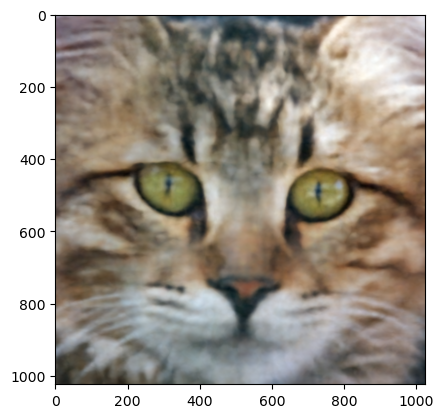

In [20]:
def create_image(resolution):
    # Create a meshgrid of positions in the range [0, 1]
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    xv, yv = np.meshgrid(x, y)
    positions = np.stack((xv, yv), axis=-1)
    
    # Convert positions to torch tensor
    x = torch.from_numpy(positions.reshape(-1, 2)).float()
    
    # Predict the RGB values using the neural network
    rgb = net(x).reshape(resolution, resolution, 3)
    
    # Ensure the RGB values are within [0, 1] range for visualization
    rgb = torch.clamp(rgb, 0, 1)
    
    return rgb.detach().cpu().numpy()

out_img = create_image(1024)
plt.imshow(out_img)
plt.show()


I am currently using CPU to run the codes since my new computer has recently come into issues with CUDA. Thus, for the following code chunk, it takes too long for my computer to react and I am afraid that I may not be able to run it on my laptop. Thus, I have changed this part to comments. I would try to run it if there is another better server.

In [ ]:

# out_img = create_image(1024*8) 
# plt.imshow(out_img)
# plt.show()

## Does the network know the face is symmetric?
No. I haven't given the neural network any specific knowledge whether the face is symmetric. Neural network won't know such specific properties of the data unless explicitly designed to recognize and consider. The current input is only pixel location by pos_enc function, and each input is dealt independently, regardless properties like symmetry. However, the Fourier positional encodings used in the network provide a rich representation that can capture spatial frequencies in the data. This can make it easier for the network to recognize and exploit symmetry if it is present in the training data.

## What would you do to enforce the network outputs symmetric signals?
I have considered a few methods as follows:
* Introduce a new type of loss term that penalizes the network for producing non-symmetric outputs. The term could possibly measure the difference between a pixel of the current output and the pixel at the mirrored position. 
* Argument the training data with the mirrored version of the image.
* Other methods like CNN to capture the domain symmetry properties but I am currently uncertain about how to achieve it and I am still working on it.

More specific application with Fourier positional encodings:
* Enhance Fourier Features. The network could easily generate symmetric patterns with access to a frequency domain representation of the positions.
* Add symmetric loss with Fourier Features. Transform the network's output to the frequency domain using a Fourier transform and define a measure to minimize the difference between the magnitudes of symmetric frequency components. 
* Implement a loss that operates in the Fourier space itself, penalizing deviations from symmetry.
* Use activation functions that are inherently periodic or have properties that can further reinforce the symmetrical properties.
